In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

Using Numpy to create sine wave data

In [3]:
x = np.linspace(0,50,501)
y = np.sin(x)

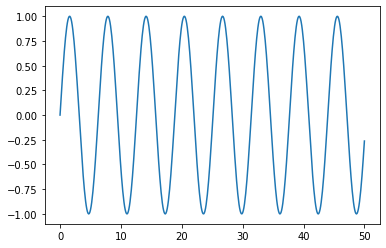

In [4]:
plt.plot(x, y)

In [6]:
df = pd.DataFrame(data=y,index=x,columns=['Sine(x)'])

In [7]:
df.head()

,Sine(x)
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418


In [8]:
len(df)

501

In [9]:
test_percent = 0.1

In [10]:
test_point = np.round(len(df)*test_percent)

In [11]:
test_ind = int(len(df) - test_point)

In [12]:
test_ind

451

Splitting into train and test data

In [13]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [14]:
train

,Sine(x)
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
0.5,0.479426
0.6,0.564642
0.7,0.644218
0.8,0.717356
0.9,0.783327


In [15]:
test

,Sine(x)
45.1,0.899097
45.2,0.938307
45.3,0.968142
45.4,0.988304
45.5,0.998591
45.6,0.998900
45.7,0.989229
45.8,0.969673
45.9,0.940429
46.0,0.901788


### Scaling Data

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [17]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [18]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [20]:
#scaled_train

In [21]:
#scaled_test

### Using Time series Generator Class

In [22]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [23]:
length = 10 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [24]:
X,y = generator[0]

In [25]:
print(f'Input: \n{X.flatten()}')
print(f'Output: \n {y}')

Input: 
[0.49999912 0.54991622 0.59933458 0.64776041 0.69470985 0.73971381
 0.78232262 0.82211054 0.85868004 0.89166571]
Output: 
 [[0.92073798]]


In [26]:
length = 50 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

### Creating Model

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SimpleRNN

In [28]:
n_features = 1

#### Simple RNN model

In [29]:
model = Sequential()

# Simple RNN layer
model.add(SimpleRNN(50,input_shape=(length, n_features)))

# Final Prediction
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50)                2600      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.fit_generator(generator,epochs=5)

Epoch 1/5
401/401 [==============================] - 25s 63ms/step - loss: 0.0082
Epoch 2/5
401/401 [==============================] - 26s 64ms/step - loss: 1.4138e-04
Epoch 3/5
401/401 [==============================] - 27s 67ms/step - loss: 1.0584e-04
Epoch 4/5
401/401 [==============================] - 26s 64ms/step - loss: 1.8714e-04
Epoch 5/5
401/401 [==============================] - 25s 64ms/step - loss: 9.5876e-05


In [32]:
model.history.history.keys()

dict_keys(['loss'])

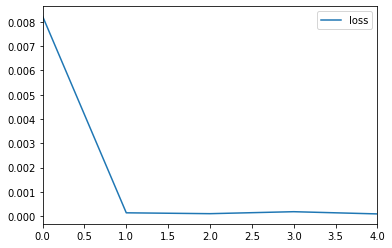

In [33]:
losses = pd.DataFrame(model.history.history)
losses.plot()

### Evaluating

In [34]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead 
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [35]:
test_predictions

[array([0.95623904], dtype=float32),
 array([0.9767014], dtype=float32),
 array([0.99441093], dtype=float32),
 array([1.0075268], dtype=float32),
 array([1.0133098], dtype=float32),
 array([1.0149118], dtype=float32),
 array([1.0100714], dtype=float32),
 array([0.9989211], dtype=float32),
 array([0.9831948], dtype=float32),
 array([0.96229756], dtype=float32),
 array([0.9348631], dtype=float32),
 array([0.90464324], dtype=float32),
 array([0.869791], dtype=float32),
 array([0.8310437], dtype=float32),
 array([0.79056543], dtype=float32),
 array([0.7461858], dtype=float32),
 array([0.6998886], dtype=float32),
 array([0.6523002], dtype=float32),
 array([0.60284954], dtype=float32),
 array([0.55168605], dtype=float32),
 array([0.5013305], dtype=float32),
 array([0.4496212], dtype=float32),
 array([0.3985416], dtype=float32),
 array([0.34928808], dtype=float32),
 array([0.29996997], dtype=float32),
 array([0.2544829], dtype=float32),
 array([0.21163425], dtype=float32),
 array([0.17185588]

In [36]:
scaled_test

array([[9.49551344e-01],
       [9.69156618e-01],
       [9.84074225e-01],
       [9.94155114e-01],
       [9.99298559e-01],
       [9.99453170e-01],
       [9.94617400e-01],
       [9.84839568e-01],
       [9.70217371e-01],
       [9.50896908e-01],
       [9.27071224e-01],
       [8.98978376e-01],
       [8.66899060e-01],
       [8.31153800e-01],
       [7.92099752e-01],
       [7.50127132e-01],
       [7.05655314e-01],
       [6.59128649e-01],
       [6.11012013e-01],
       [5.61786173e-01],
       [5.11942978e-01],
       [4.61980443e-01],
       [4.12397778e-01],
       [3.63690397e-01],
       [3.16344967e-01],
       [2.70834550e-01],
       [2.27613868e-01],
       [1.87114770e-01],
       [1.49741909e-01],
       [1.15868702e-01],
       [8.58335998e-02],
       [5.99367021e-02],
       [3.84367625e-02],
       [2.15486014e-02],
       [9.44095974e-03],
       [2.23481297e-03],
       [2.16257798e-06],
       [2.76531647e-03],
       [1.04966661e-02],
       [2.31189624e-02],


In [37]:
true_predictions = scaler.inverse_transform(test_predictions)

In [38]:
test

,Sine(x)
45.1,0.899097
45.2,0.938307
45.3,0.968142
45.4,0.988304
45.5,0.998591
45.6,0.998900
45.7,0.989229
45.8,0.969673
45.9,0.940429
46.0,0.901788


In [39]:
test['Predictions'] = true_predictions

d:\mltensor\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [40]:
test

,Sine(x),Predictions
45.1,0.899097,0.912473
45.2,0.938307,0.953397
45.3,0.968142,0.988816
45.4,0.988304,1.015047
45.5,0.998591,1.026613
45.6,0.998900,1.029817
45.7,0.989229,1.020136
45.8,0.969673,0.997836
45.9,0.940429,0.966384
46.0,0.901788,0.924589


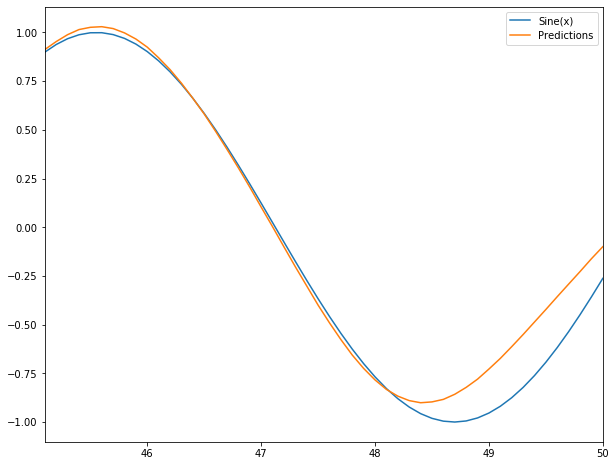

In [41]:
test.plot(figsize=(10,8))

### Adding Early stopping

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

In [44]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [45]:
length = 49
generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length=length,batch_size=1)


validation_generator = TimeseriesGenerator(scaled_test,scaled_test,
                                          length=length,batch_size=1)

### LSTM Model

In [47]:
model = Sequential()

# Simple RNN layer
model.add(LSTM(50,input_shape=(length, n_features)))

# Final Prediction
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [48]:
model.fit_generator(generator,epochs=20,
                   validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
402/402 [==============================] - 11s 27ms/step - loss: 0.0174 - val_loss: 4.4691e-05
Epoch 2/20
402/402 [==============================] - 9s 21ms/step - loss: 1.8369e-04 - val_loss: 9.5621e-05
Epoch 3/20
402/402 [==============================] - 9s 22ms/step - loss: 2.7068e-04 - val_loss: 3.3705e-06
Epoch 4/20
402/402 [==============================] - 8s 20ms/step - loss: 3.2455e-04 - val_loss: 1.4036e-05
Epoch 5/20
402/402 [==============================] - 9s 22ms/step - loss: 8.4551e-05 - val_loss: 1.1093e-05


In [49]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

d:\mltensor\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


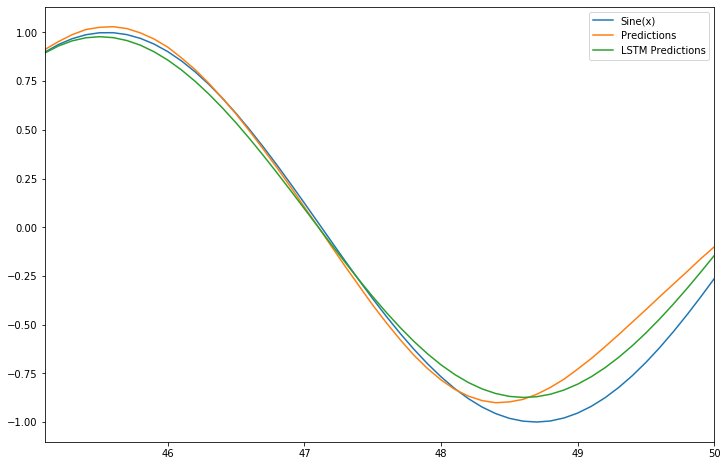

In [50]:
true_predictions = scaler.inverse_transform(test_predictions)
test['LSTM Predictions'] = true_predictions
test.plot(figsize=(12,8))

### Forecasting Future Values

In [51]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [52]:
length = 50 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [53]:
model = Sequential()
model.add(LSTM(50, input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=5)

Epoch 1/5
451/451 [==============================] - 9s 21ms/step - loss: 0.0128
Epoch 2/5
451/451 [==============================] - 9s 19ms/step - loss: 1.6592e-04
Epoch 3/5
451/451 [==============================] - 10s 22ms/step - loss: 2.0038e-04
Epoch 4/5
451/451 [==============================] - 9s 21ms/step - loss: 2.0011e-04
Epoch 5/5
451/451 [==============================] - 9s 20ms/step - loss: 5.8710e-05


In [54]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [55]:
forecast = scaler.inverse_transform(forecast)

In [56]:
forecast_index = np.arange(50.1,55.1,step=0.1)

In [61]:
len(forecast_index)

50

In [64]:
df.index

Float64Index([                0.0,                 0.1,                 0.2,
              0.30000000000000004,                 0.4,                 0.5,
               0.6000000000000001,  0.7000000000000001,                 0.8,
                              0.9,
              ...
                             49.1,                49.2,  49.300000000000004,
               49.400000000000006,                49.5,                49.6,
                             49.7,  49.800000000000004,  49.900000000000006,
                             50.0],
             dtype='float64', length=501)

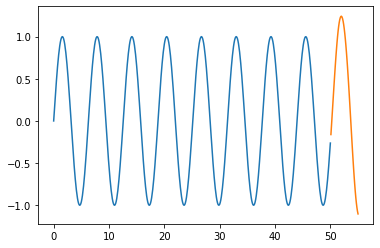

In [67]:
plt.plot(df.index.values,df['Sine(x)'].values)
plt.plot(forecast_index,forecast)